# Workflow Leyenda
## Importation des bibliothèques

In [1]:
import scipy
from scipy import ndimage
import numpy as np
import imageio
import matplotlib.pyplot as plt
import cv2 as cv
import os
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Importation des données de test

In [2]:
validation_folder = "validation"

validation_images = []
validation_images_path = []

for subdir, dirs, files in os.walk(validation_folder):
    for file in files:
        filepath = subdir + os.sep + file
        print (filepath)
        validation_images.append(imageio.imread(filepath))
        validation_images_path.append(filepath)

print("\n{} images loaded".format(len(validation_images)))

validation\3749-SKYZUNE ART-PANTOUFLE-24X30-BD.jpg
validation\61259323.jpg
validation\exemple-comment-ecrire-sur-une-photo.jpg
validation\how-to-create-a-photorealistic-digital-painting-in-sketchbook-pro_132.jpg
validation\jean-francois-millet.-les-glaneuses-1857-.jpg
validation\Peintures-photorealistes-alimentaires-4.jpg
validation\ROBERTO BERNARDI, candy rainbow, 2010, huile sur toile, 87x125 cm.jpg

7 images loaded


## Classification

In [3]:
img_height = 96
img_width = 96
num_classes = 2

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

def create_model():
    model = Sequential([
        #data_augmentation,
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(8, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.6),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model

In [22]:
# Restauration du modèle
model = create_model()
model.load_weights('saved models/norm_yes-dropout0.6-batch_50-pix_96-epoch20-Matrix_8-16-32-64-class_2')

16 classified images


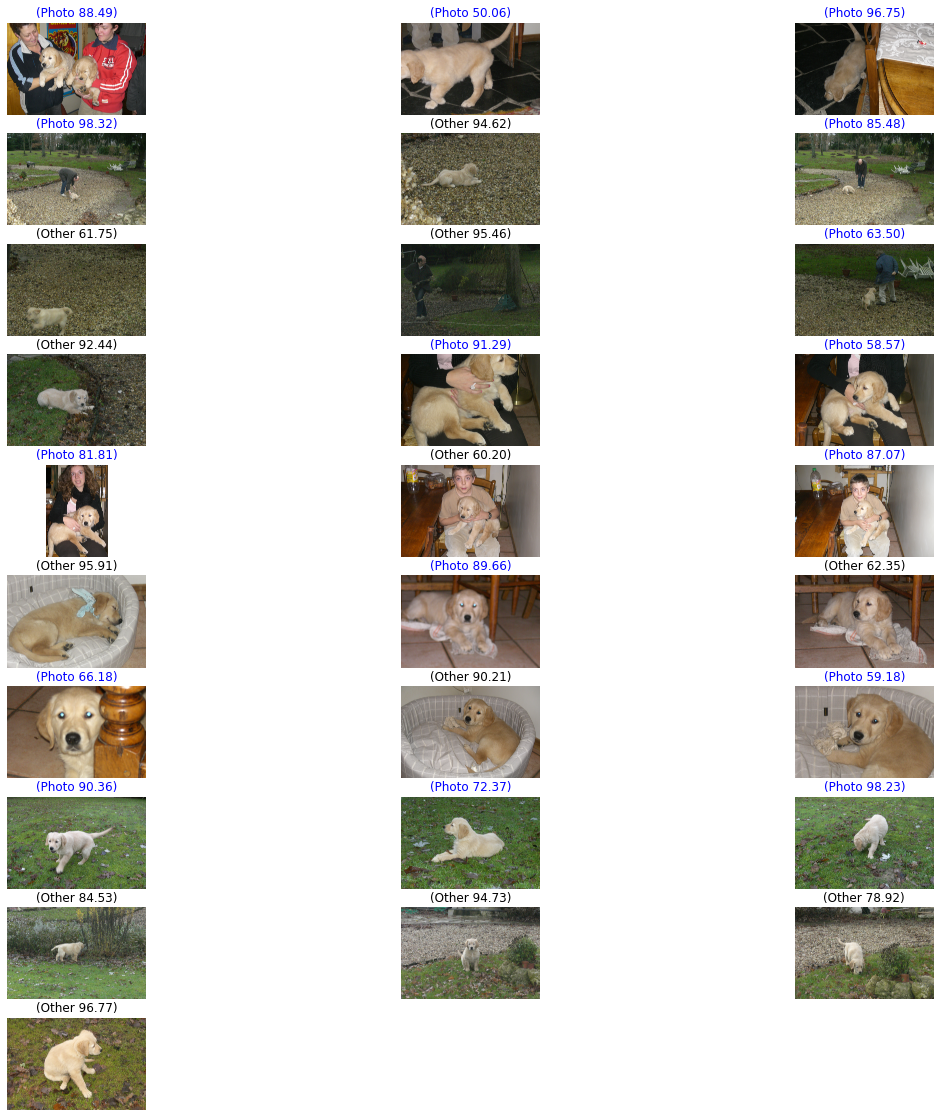

In [38]:
class_names = ["Other", "Photo"]
classified_images = []

plt.figure(figsize=(20, 20))
for i in range(len(validation_images_path)):
    img = keras.preprocessing.image.load_img(
        validation_images_path[i], target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    ax = plt.subplot(math.ceil(len(validation_images) / 3), 3, i + 1)
    plt.imshow(validation_images[i])
    title = plt.title("({} {:.2f})".format(class_names[np.argmax(score)], 100 * np.max(score)))
    plt.axis("off")
    
    if np.argmax(score) == 1:
        classified_images.append(validation_images[i])
        plt.setp(title, color='b')
    
print("{} classified images".format(len(classified_images)))

## Prétraitement

In [35]:
def fullPreProcess(image, medianBlur=3, kernel=np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])):
    image = cv.medianBlur(image, 3)
    image = cv.filter2D(image, -1, kernel)
    return image

In [36]:
preprocess_images = []
for image in classified_images:
    preprocess_images.append(
        fullPreProcess(image)
    )

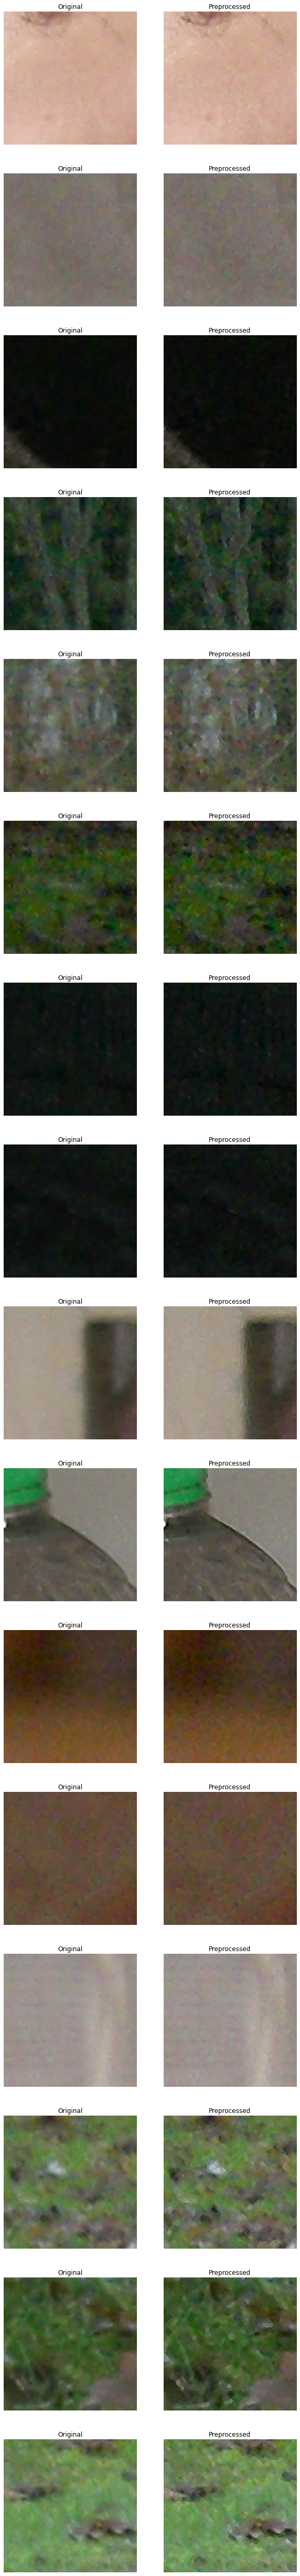

In [37]:
bool_zoom = True
fig = plt.figure(figsize=(10, math.ceil(len(classified_images) / 3) * 15))
for i in range(len(classified_images)):
    plt.subplot(len(classified_images), 2, i * 2 + 1)
    plt.imshow(classified_images[i])
    plt.title("Original")
    plt.axis("off")
    if (bool_zoom):
        plt.xlim(400, 500)
        plt.ylim(200,100)
    
    plt.subplot(len(classified_images), 2, i * 2 + 2)
    plt.imshow(preprocess_images[i])
    plt.title("Preprocessed")
    plt.axis("off")
    if (bool_zoom):
        plt.xlim(400, 500)
        plt.ylim(200,100)

## Sous-titrage